In [2]:
import io
from pathlib import Path
import re

import fasttext
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import wordcloud

BASE_DATA_DIR = Path.cwd().parent / "data"

In [3]:
df_true = pd.read_csv(BASE_DATA_DIR / "raw" / "True.csv")
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
df_fake = pd.read_csv(BASE_DATA_DIR / "raw" / "Fake.csv")
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
df_true["is_fake"] = False
df_merged = pd.concat([df_true, df_fake])
df_merged["is_fake"].fillna(True, inplace=True)
df_merged.reset_index(drop=True, inplace=True)

<AxesSubplot:xlabel='is_fake', ylabel='count'>

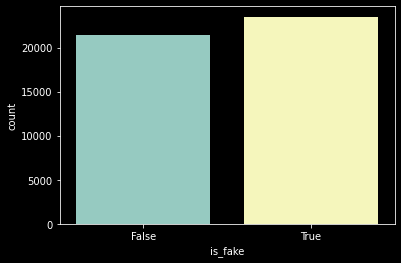

In [6]:
sns.countplot(x="is_fake", data=df_merged)

<AxesSubplot:xlabel='count', ylabel='subject'>

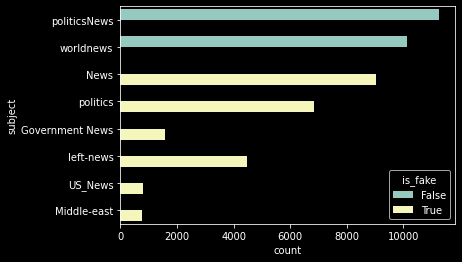

In [7]:
sns.countplot(y="subject", data=df_merged, hue="is_fake")

It doesn't seem that subjects overlap at all.

In [8]:
df_merged["num_words_text"] = df_merged["text"].str.strip().str.split().str.len()

In [9]:
df_merged["num_words_text"].describe()

count    44898.000000
mean       405.282284
std        351.265595
min          0.000000
25%        203.000000
50%        362.000000
75%        513.000000
max       8135.000000
Name: num_words_text, dtype: float64

In [10]:
df_merged[df_merged["num_words_text"] == 0]

,title,text,subject,date,is_fake,num_words_text
8970,Graphic: Supreme Court roundup,,politicsNews,"June 16, 2016",False,0
32340,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017",True,0
32458,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017",True,0
32607,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017",True,0
32642,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017",True,0
...,...,...,...,...,...,...
43233,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015",True,0
43243,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015",True,0
43244,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015",True,0
43274,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015",True,0


<AxesSubplot:xlabel='num_words_text', ylabel='Count'>

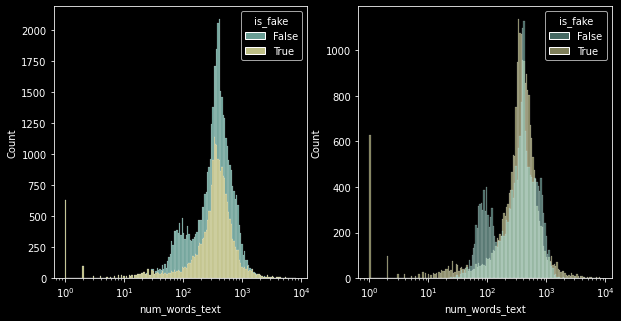

In [11]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.histplot(
    x=df_merged.num_words_text + 1,
    hue=df_merged.is_fake,
    log_scale=(True, False),
    multiple="stack",
)

plt.subplot(1, 2, 2)
sns.histplot(
    x=df_merged.num_words_text + 1,
    hue=df_merged.is_fake,
    log_scale=(True, False),
    multiple="layer",
)

In [12]:
wc_true = wordcloud.WordCloud(width=650, height=400, background_color="white").generate(
    " ".join(df_true.text)
)
wc_fake = wordcloud.WordCloud(width=650, height=400, background_color="white").generate(
    " ".join(df_fake.text)
)

'True news word cloud'

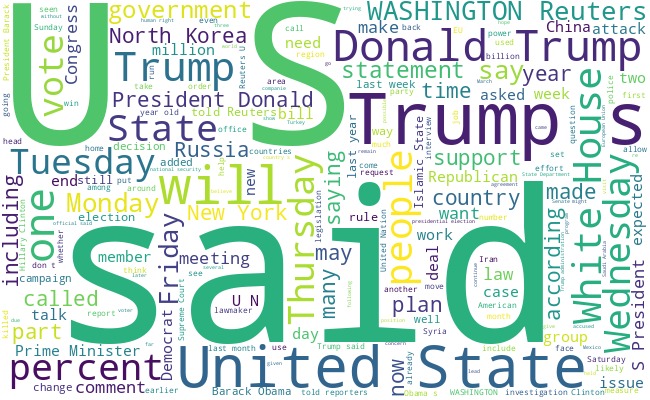

In [13]:
display("True news word cloud", wc_true.to_image())

'Fake news word cloud'

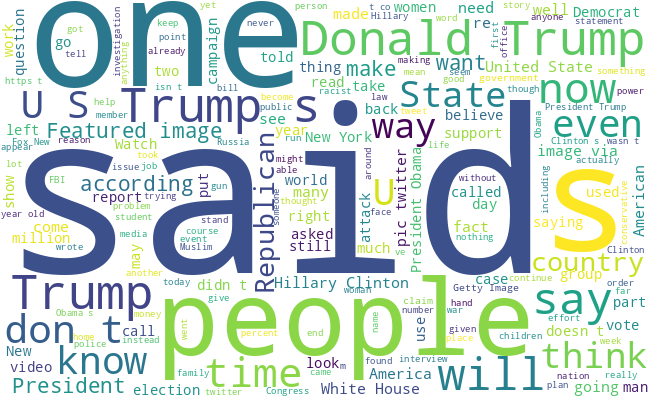

In [14]:
display("Fake news word cloud", wc_fake.to_image())

Honnestly, it's hard to see something useful here. News are mostly about Donald Trump or USA.

In [15]:
vect_true = TfidfVectorizer(
    max_features=20,
    strip_accents="ascii",
    analyzer="word",
    lowercase=True,
    stop_words=wc_true.stopwords,
).fit(df_true.text)

/home/julius/lp/Turing/jjuoda-DL.4/venv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


In [16]:
vect_true.get_feature_names_out()

array(['election', 'government', 'house', 'last', 'new', 'one', 'people',
       'president', 'republican', 'reuters', 'said', 'state', 'states',
       'told', 'trump', 'two', 'united', 'washington', 'will', 'year'],
      dtype=object)

In [17]:
vect_fake = TfidfVectorizer(
    max_features=20,
    strip_accents="ascii",
    analyzer="word",
    lowercase=True,
    stop_words=wc_fake.stopwords,
).fit(df_fake.text)
vect_fake.get_feature_names_out()

array(['clinton', 'donald', 'even', 'hillary', 'new', 'news', 'now',
       'obama', 'one', 'people', 'president', 're', 'said', 'state',
       'time', 'trump', 'us', 'via', 'white', 'will'], dtype=object)

I see Reuters being mentioned in true news a lot. Fake news mention Hillary Clinton and Barack Obama quite a bit.

In [18]:
with pd.option_context("display.max_colwidth", None):
    print(df_true.sample(frac=1).head(5).text)

5305                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [19]:
df_true.text.apply(lambda x: "reuters" in x.lower()).mean()

0.9981790166690012

In [20]:
df_fake.text.apply(lambda x: "reuters" in x.lower()).mean()

0.013713214939738512

Seems like only reuters news were taken and if I leave that, any model will just learn to check if reuters exist in the text.

In [21]:
with pd.option_context("display.max_colwidth", None):
    print(df_fake.sample(frac=1).head(5).text)

708                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               With a very dramatic flair, Senator John McCain joined his Republican colleagues, Sens

Hm, there seems to be disconnected apostrophes and missing punctuation in general. The texts also feel more emotional. Somes "news" from Breitbart. Also feels like Twitter.

In [22]:
def drop_news_source_names(text):
    # signs of Reuters
    location_reuters_pat = r"^([A-Z/,. ]+ )?\(Reuters\) - "
    text = re.sub(location_reuters_pat, "", text, flags=re.IGNORECASE)
    reuters_in_text_pat = r"Reuters"
    text = re.sub(reuters_in_text_pat, "", text, flags=re.IGNORECASE)

    # signs of Breitbart
    breitbart_pat = r"Breitbart( News)?"
    text = re.sub(breitbart_pat, "", text, flags=re.IGNORECASE)

    # Signs of Twitter
    # I'm not sure if this needs dropping; the "news" is that Trump said something on Twitter, which is verifiably true
    # If we remove the disclaimer, what's left is Trump's tweet itself which can be false
    # I guess w/e, 4 samples in total have this disclaimer :D
    twitter_disclaimer_pat = r"^The following statements were posted to the verified Twitter accounts of U.S. President Donald Trump, @realDonaldTrump and @POTUS.  The opinions expressed are his own.  has not edited the statements or confirmed their accuracy."
    text = re.sub(twitter_disclaimer_pat, "", text, flags=re.IGNORECASE)
    twitter_replies_pat = (
        r"(\w+ \w+\s+)?"  # optional first name and last name
        r"\(@\w+\) "  # twitter handle
        r"\w+ \d+, \d+"  # date
    )
    text = re.sub(twitter_replies_pat, "", text, flags=re.IGNORECASE)
    photo_source_pat = r"Photo by \w+ \w+/Getty Images"
    text = re.sub(photo_source_pat, "", text, flags=re.IGNORECASE)
    twitter_mentions_pat = r"@\w+"
    text = re.sub(twitter_mentions_pat, "", text, flags=re.IGNORECASE)
    twitter_tags_pat = r"#\w+"
    text = re.sub(twitter_tags_pat, "", text, flags=re.IGNORECASE)
    tweet_title_pat = r"\(TWEETS?\)"
    text = re.sub(tweet_title_pat, "", text, flags=re.IGNORECASE)

    image_title_pat = r"\(IMAGE\)"
    text = re.sub(image_title_pat, "", text, flags=re.IGNORECASE)
    video_title_pat = r"\(VIDEO\)"
    text = re.sub(video_title_pat, "", text, flags=re.IGNORECASE)

    end_source_pat = r"Via: .+$"
    text = re.sub(end_source_pat, "", text)
    end_picture_pat = r"Featured Image via .*$"
    text = re.sub(end_picture_pat, "", text, flags=re.IGNORECASE)
    link_pat = r"(http(s)?:\/\/.)?(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)"
    text = re.sub(link_pat, "", text)

    return text


def clean_text(text):
    text = drop_news_source_names(text)
    text = text.strip()
    return text

In [23]:
df_merged["text"] = df_merged.text.apply(drop_news_source_names)
df_true["text"] = df_true.text.apply(drop_news_source_names)
df_fake["text"] = df_fake.text.apply(drop_news_source_names)

In [24]:
df_merged["num_words_text"] = df_merged["text"].str.strip().str.split().str.len()

In [25]:
with pd.option_context("display.max_colwidth", None):
    print(df_true.sample(frac=1).head(5).title)

6614                             Trump hotels reach deal with unions, ending labor board cases
13952    North Korea replaces soldiers, South Korea awards medals after defector's border dash
19804                                   South Africa tax agency wants parliament to probe KPMG
6306                             Germany says in interests of EU and U.S. to pursue TTIP talks
4700                                  Trump tells House leaders to cancel healthcare bill vote
Name: title, dtype: object


In [26]:
with pd.option_context("display.max_colwidth", None):
    print(df_fake.sample(frac=1).head(5).title)

9567                             DONALD TRUMP JR. Had The Best Reply Ever When He Discovered A Certain Republican Was Planning To Run Again In 2020
4231                                                              Trump EXPLODES Because Paul Ryan Won’t Defend Him, Launches INSANE Attack (VIDEO)
21809    [VIDEO] LEFTIST CNN ANCHOR TELLS RACIST US REP THE #BaltimoreRiots Are Vets Fault “They come back from war…and they’re ready to do battle”
8954                                                                        This Insane GOP Congressman WANTS The Mentally Ill To Have Guns (TWEET)
19382                               HIV POSITIVE, CRACK SMOKING, Liberal Actor Charlie Sheen Wishes Death On Donald Trump…Gets DESTROYED On Twitter
Name: title, dtype: object


Fake news SHOUT a lot. Also mention [VIDEO] or (VIDEO) in the title.

In [27]:
def count_all_upper_words(text):
    return sum(word.isupper() for word in text.split())


print(df_true.title.apply(count_all_upper_words).mean())
print(df_fake.title.apply(count_all_upper_words).mean())

0.38810290890414156
3.254759166986074


In [28]:
df_true.title.str.contains("VIDEO").mean()

0.0

In [29]:
df_fake.title.str.contains("VIDEO").mean()

0.2327413653592266

Can I drop "VIDEO" from title and still have enough information that this is fake news?

In [30]:
with pd.option_context("display.max_colwidth", None):
    idx = df_fake[df_fake.title.str.contains("VIDEO")].sample(frac=1).head(5).index
    print(df_fake.loc[idx, ["title", "text"]])

                                                                                                            title  \
5663                       Bystander Uses Baseball Bat To Stop Man From Crushing Toddler’s Head ‘For God’ (VIDEO)   
19082      UNPRECEDENTED: New York Times To Run 30 Sec Ad During Oscars…Bashing Trump…Defending FAKE News [VIDEO]   
13220  BOOM! Poll Shows Support For Trump With Blacks SURGES…DESTROYS Romney’s Numbers With LATINO Voters [VIDEO]   
21045         HOW HILLARY CLINTON Has Secured Her Husband’s Legacy As “A Rapist” And Hers As An “Enabler” [VIDEO]   
7095                   Donald Trump Attacks Obama, Says He Understands The World ‘Much Better’ Than POTUS (VIDEO)   

                                                                                                                                                                                                                                                                                                         

Easily if I keep casing. If not, emotional baggage still seems to be there, so maybe not by hard rules, but nlp model should be able to pick that up.

In [31]:
df_merged["title"] = df_merged["title"].str.replace(
    r"(\(|\[)VIDEO(\]|\))", "", regex=True, flags=re.IGNORECASE
)

In [32]:
df_merged["title"] = df_merged.title.apply(drop_news_source_names)
df_true["title"] = df_true.title.apply(drop_news_source_names)
df_fake["title"] = df_fake.title.apply(drop_news_source_names)

In [33]:
df_merged["num_words_title"] = df_merged["title"].str.strip().str.split().str.len()

In [34]:
df_merged.to_csv(BASE_DATA_DIR / "final/merged.csv", index=False)